### Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 1.11.0
torchvision version: 0.12.0


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "CPU"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create datasets and dataloaders

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224 #comes from table 3 of viT paper

#create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
                                        ])

print(f"Manually Create Transforms: {manual_transforms}")

Manually Create Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [7]:
# create a batch size of 32 the paper uses a batch size of 496
BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
    )

In [8]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

# Visualizing a Single Image

In [9]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(-0.5, 223.5, 223.5, -0.5)

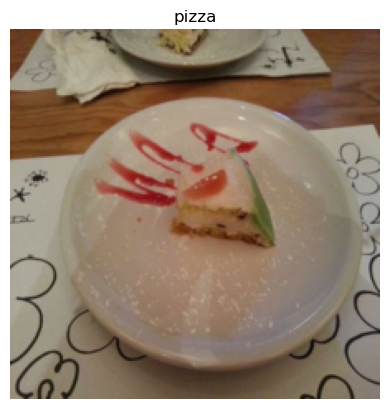

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

3.1 VISION TRANSFORMER (VIT)

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.




$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$


**Equation 1**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In psuedocode:

```x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_post, image_patch_1_pos + image_patch_2_pos, ... image_patch_N_pos]```



**Equation 2 & 3**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In Pseudocode:

```x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input```
```x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block```





**Equation 4**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right.$ ), whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.


In Psuedocode:

```y = Linear_layer(LN_layer(x_output_MLP_block))```

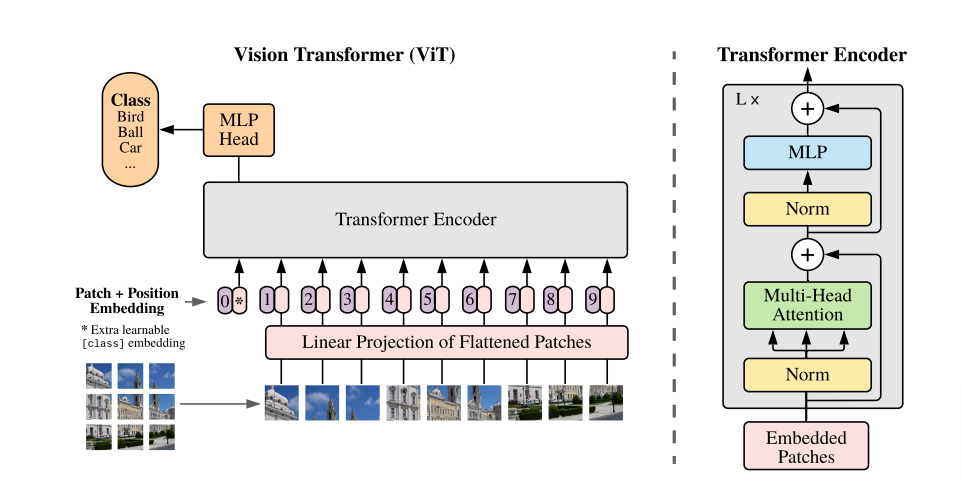

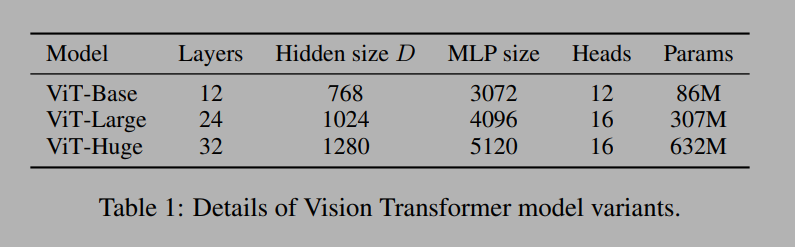

* Layers = Number of Transformer encoder layers (12)
* Hidden Size $D$ - The embedding size throughout the architecture (16x16 image => 768 sized vector)
* MLP Size - The number of hidden units/ neuron in the MLP ( 3072 Hidden Layer)
* Head = The number of multi-head self attention layers (12)

## Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output
* Input Shape = (224, 224, 3) -> (height, width, color channel)
* Output Shape = ${N \times\left (P^{2} \cdot C\right)}$

* H = Height
* W = Width 
* C = color channel
* P = Patch Size 
* N = number of patches = (height * width)/ p^2
* D = constant latent vector size = embedding dimension


In [ ]:
height = 224
width = 224
color_channels =3 
patch_size = 16

# calculate number of patches

number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [ ]:
# input_shape
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2d image): {embedding_layer_input_shape}")
print(f"Output shape (single 1d image): {embedding_layer_output_shape} => (number_of_patches, embedding_dimension)")

Input shape (single 2d image): (224, 224, 3)
Output shape (single 1d image): (196, 768) => (number_of_patches, embedding_dimension)


# Turning image into patches

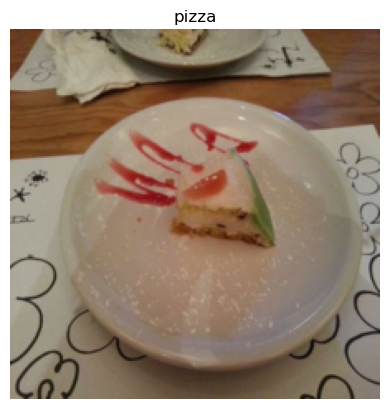

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
image.shape

torch.Size([3, 224, 224])

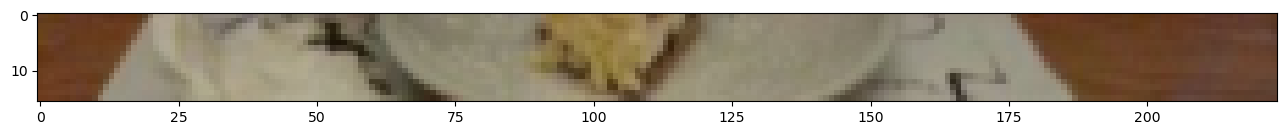

In [ ]:
image_permuted = image.permute(1, 2, 0) # convert image to color channels last

# index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


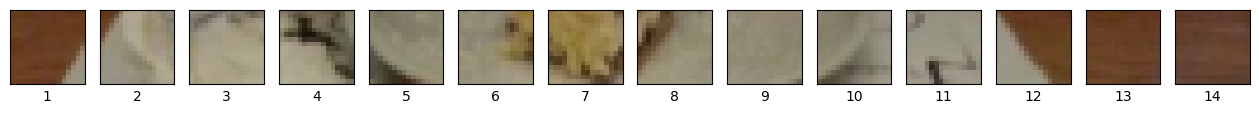

In [ ]:
# setup code to plot top row as patches 

img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(
    nrows = 1, 
    ncols=img_size// patch_size, # one column for each patch
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
    )
# iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size, :])
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
 Number of Patches per column: 14.0
Total patches:196.0
Patch size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'pizza =>patchsize')

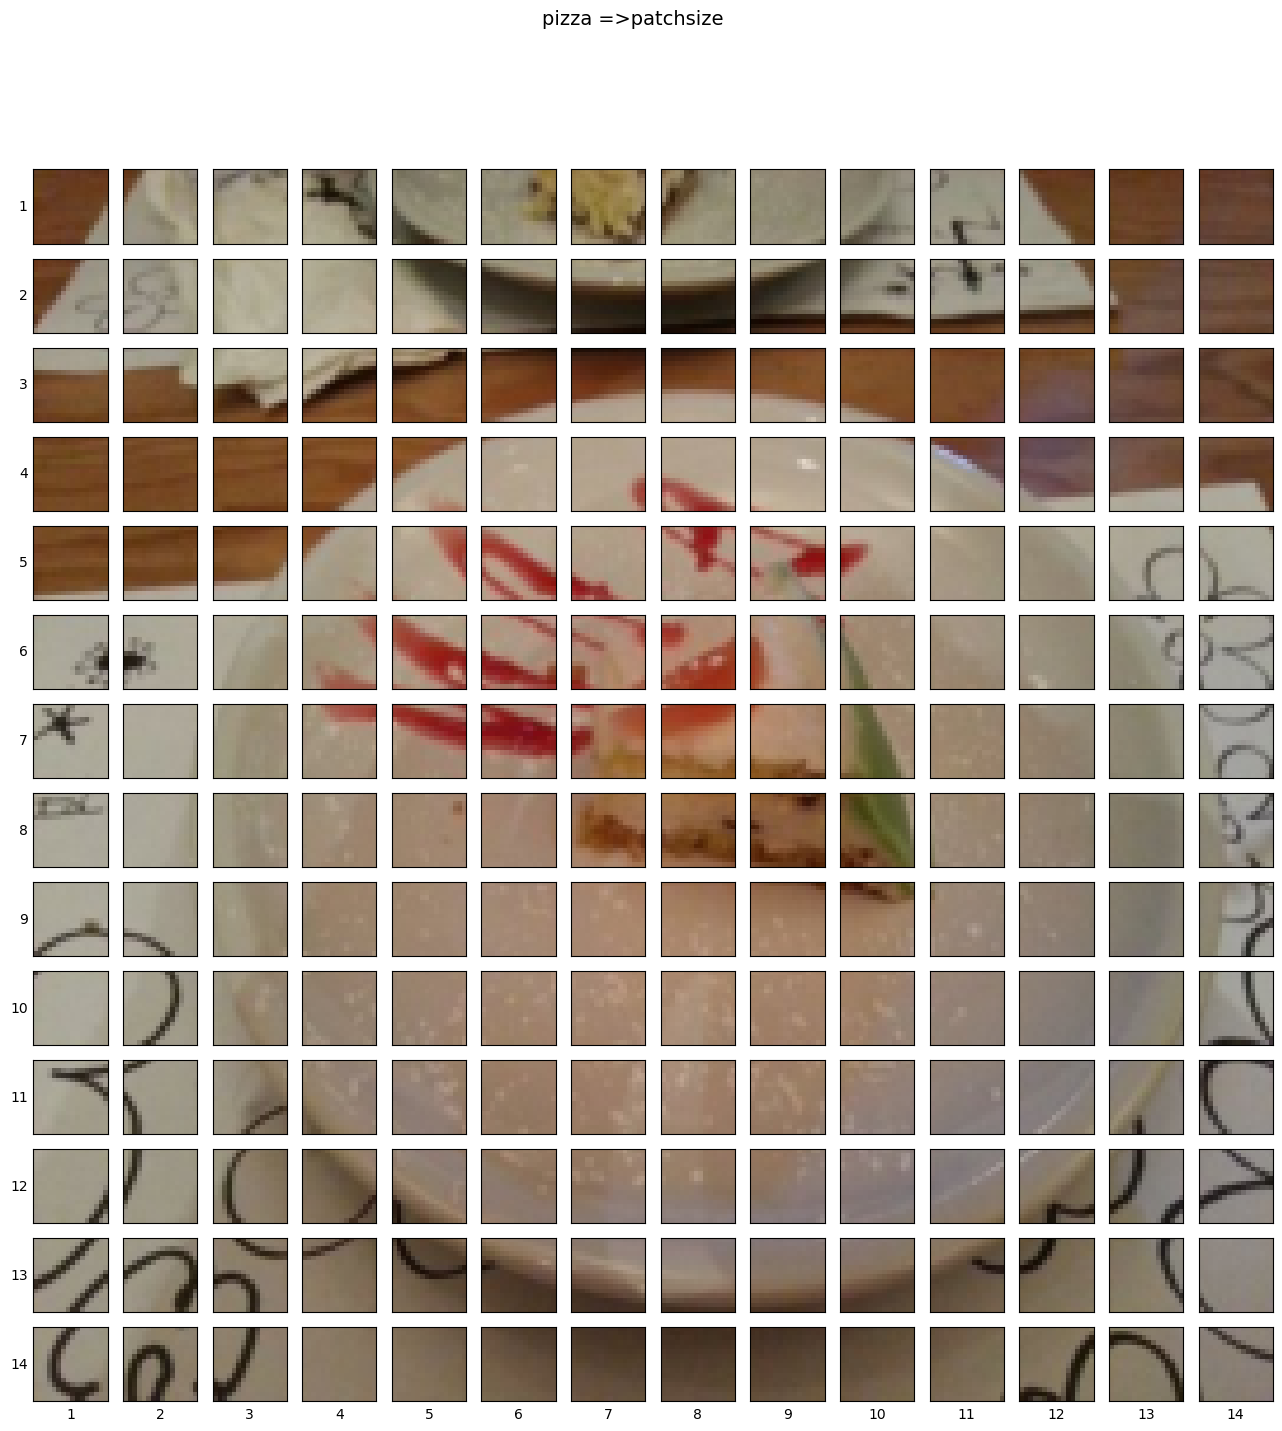

In [ ]:
# setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}\n Number of Patches per column: {num_patches}\nTotal patches:{num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(
    nrows = img_size// patch_size, 
    ncols=img_size// patch_size, # one column for each patch
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
    )

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    # print(i, height_patch)
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width: patch_width+patch_size, :])
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center") # set the patch label
        axs[i, j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()
fig.suptitle(f"{class_names[label]} =>patchsize", fontsize=14)

### Creating Image patches and turning them into patch embeddings
We can use the torch.nn.conv2d() and set the kernel size and stride values to patch size

In [ ]:
# create conv2d layer to turn image into patches of learnable feature maps
from torch import nn

patch_size = 16

#create a conv2d layer with hyperparameters from ViT paper
conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride = patch_size, padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
# pass the image through the convolution layer
print(image.shape)
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


`torch.Size([1, 768, 14, 14])` -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indexes: [191, 556, 307, 86, 687]


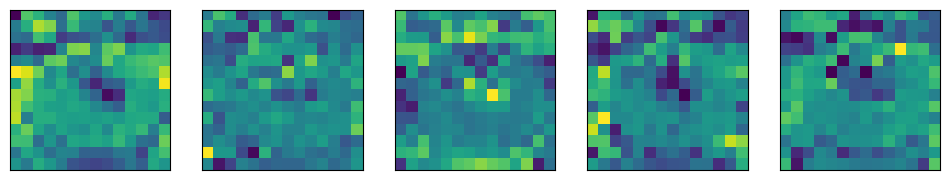

In [ ]:
# plot random convolutional feature maps

import random
random_indexes = random.sample(range(0, 758), k=5)

print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map= image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/ switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [ ]:
# get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.1973, -0.3005, -0.4416, -0.4304, -0.2091, -0.4381, -0.3699,
           -0.3637, -0.3811, -0.2350, -0.2866, -0.4127, -0.2397, -0.2376],
          [-0.3350, -0.3436, -0.4500, -0.4622, -0.4756, -0.2077, -0.2820,
           -0.2299, -0.1539, -0.1669, -0.2267, -0.3164, -0.2607, -0.2406],
          [-0.3546, -0.3090, -0.3027, -0.2854, -0.2692, -0.3204, -0.3446,
           -0.3765, -0.3954, -0.3796, -0.2842, -0.2768, -0.2317, -0.2393],
          [-0.2835, -0.2848, -0.2832, -0.2564, -0.4050, -0.4272, -0.4840,
           -0.3681, -0.4720, -0.4565, -0.4275, -0.3013, -0.3560, -0.4380],
          [-0.2968, -0.3409, -0.3626, -0.3529, -0.5168, -0.4293, -0.3097,
           -0.4116, -0.4366, -0.4074, -0.4195, -0.3515, -0.3979, -0.3473],
          [-0.4648, -0.4680, -0.4254, -0.3821, -0.4473, -0.3590, -0.3945,
           -0.3963, -0.4740, -0.3328, -0.3754, -0.4179, -0.3186, -0.4185],
          [-0.3085, -0.4436, -0.3916, -0.4220, -0.3626, -0.3465, -0.4298,
           -0.3218, -0.3403, -0.

In [ ]:
### Flattening the patch embeddings with torch.nn.flatten()
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_height, feature_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_height, feature_width)


Want: (batch_size, number_of_patches, embedding_dim) -> [1, 768, 196]

In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


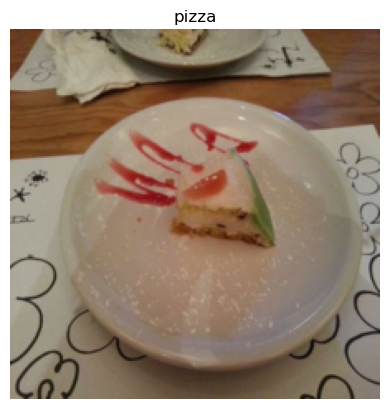

In [ ]:
plt.imshow(image.permute(1, 2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

#Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Image out of conv flattened: {image_out_of_conv_flattened.permute(0, 2, 1).shape}-> (batch_size, number_of_patches, embedding_dim)")

Image out of conv flattened: torch.Size([1, 196, 768])-> (batch_size, number_of_patches, embedding_dim)


(-0.5, 195.5, 0.5, -0.5)

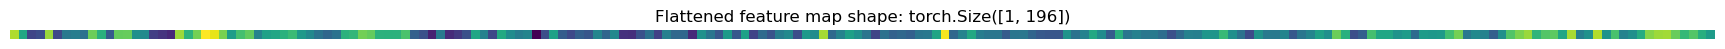

In [ ]:
# get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)


### Turning the ViT patch embedding layer into pytorch module

1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimensions, patch size
3. Create a layer to turn an image into embedding patches using nn.Conv2D
4. Create a layer to flatten the feature maps of the output the layer in 3
5. Define a `forward()` that defined the forward computation (eg. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [ ]:
# 1. Create a class called `PatchEmbedding`
class PatchEmbedding(nn.Module):
    #2. Initialize with appropriate hyperparameters, such as channels, embedding dimensions, patch size
    def __init__(self,
                 in_channels: int =3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        self.patch_size = patch_size
        # 3. Create a layer to turn an image into embedding patches using nn.Conv2D
        self.patcher = nn.Conv2d(in_channels=in_channels, 
                                 out_channels = embedding_dim, 
                                 kernel_size = patch_size,
                                 stride= patch_size,
                                 padding=0
                                 )
        # 4. Create a layer to flatten feature map outputs of Conv2D
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        # 5. Define a forward method to define the forward computation steps
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size ==0, f"Input image size must be divisible by patch_size, image shape: {image_resolution}, patch_size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make the returned sequence embedding dimensions are in the right order ( batch_size, number_of_patches, embedding_dimension)
        return x_flattened.permute(0, 2, 1)




In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify= PatchEmbedding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

print(f"Input image Size: {image.unsqueeze(0).shape}") # add an extra batch dimension
patch_embedded_image = patchify(image.unsqueeze(0))

print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")


Input image Size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

### Creating the class token embedding
Want to: Prepend a learnable classtoken to the start of the patch embedding

In [ ]:
patch_embedded_image

tensor([[[-0.4627,  0.0406, -0.0755,  ...,  0.2322, -0.1194,  0.1808],
         [-0.7322,  0.1793, -0.2027,  ...,  0.4845, -0.1792,  0.2178],
         [-0.6636,  0.1606, -0.1919,  ...,  0.4433, -0.1970,  0.2617],
         ...,
         [-0.4862, -0.0189,  0.0287,  ...,  0.2724, -0.1951,  0.2769],
         [-0.3854,  0.1527, -0.2302,  ...,  0.3121, -0.1695,  0.1828],
         [-0.4576,  0.1076, -0.1736,  ...,  0.3590, -0.2313,  0.1783]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# create class token embeddings as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding

patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1) #number of patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4627,  0.0406, -0.0755,  ...,  0.2322, -0.1194,  0.1808],
         [-0.7322,  0.1793, -0.2027,  ...,  0.4845, -0.1792,  0.2178],
         ...,
         [-0.4862, -0.0189,  0.0287,  ...,  0.2724, -0.1951,  0.2769],
         [-0.3854,  0.1527, -0.2302,  ...,  0.3121, -0.1695,  0.1828],
         [-0.4576,  0.1076, -0.1736,  ...,  0.3590, -0.2313,  0.1783]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])


### 4.7 Creating the position embedding

Want to create a series of 1D learnable positiong embeddings and to add them to the sequence of patch embeddings

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4627,  0.0406, -0.0755,  ...,  0.2322, -0.1194,  0.1808],
          [-0.7322,  0.1793, -0.2027,  ...,  0.4845, -0.1792,  0.2178],
          ...,
          [-0.4862, -0.0189,  0.0287,  ...,  0.2724, -0.1951,  0.2769],
          [-0.3854,  0.1527, -0.2302,  ...,  0.3121, -0.1695,  0.1828],
          [-0.4576,  0.1076, -0.1736,  ...,  0.3590, -0.2313,  0.1783]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number_of_patches)
number_of_patches = int((height*width)/patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
## Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5373, 1.0406, 0.9245,  ..., 1.2322, 0.8806, 1.1808],
         [0.2678, 1.1793, 0.7973,  ..., 1.4845, 0.8208, 1.2178],
         ...,
         [0.5138, 0.9811, 1.0287,  ..., 1.2724, 0.8049, 1.2769],
         [0.6146, 1.1527, 0.7698,  ..., 1.3121, 0.8305, 1.1828],
         [0.5424, 1.1076, 0.8264,  ..., 1.3590, 0.7687, 1.1783]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

We have written code to torun image in a flattened sequence of patch embeddings.
now lets it all in one cell

In [ ]:
set_seeds()

# set the patch size
patch_size = 16

# Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")

height, width = image.shape[1], image.shape[2]

# get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# create a patch embedding layer 
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768
                                       )
# 5. Pass input image through the embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,  embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token embedding shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width)/ patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches +1, embedding_dimension), requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token embedding shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [ ]:
image.shape

torch.Size([3, 224, 224])

### Equation 2: Multihead self attention(MSA Block)

* Multihead self attention means which part of a sequence should pay the most attention to itself?

* In our case, we have a series of embedded image patches, which patch signifcantly related to another patch.

We want our neural network (ViT) to learn this relationship/ representation

* LayerNorm: Layer Normalization is a technique to normalize the distribution of intermediate layers. It enables smoother gradients, faster training and better generalization accuracy.

* Normalization = make everything have the same mean and same standard deviation
* In pytorch nomalizes values over $D$ dimension, in our case the $D$ dimension is the embedding dimension
* When we normalize along the embedding dimension, it's like making alll of the stairs in a staircase same size.

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block("MSA Block") """
    def __init__(self, 
                 embedding_dim:int = 768, # Hidden size D
                 num_heads:int = 12, # Heads from Table 1 for ViT Base
                 attn_dropout: int=0
                 ):
        super().__init__()
        # Create a Norm Layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create a multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True, # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
                                                    )
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, 
                                             key =x, 
                                             value=x,
                                             need_weights = False,
                                             )
        return attn_output


In [ ]:
# Create an instance MSA Block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768, num_heads=12, attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA Block
patched_image_thourgh_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Input shape of MSA Block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA Block: {patched_image_thourgh_msa_block.shape}")

Input shape of MSA Block: torch.Size([1, 197, 768])
Output shape of MSA Block: torch.Size([1, 197, 768])


## Equation 3: Multilayer Perceptron

* **MLP** = The MLP contains two layers with a GELU non-linearity. (Section 3.1)
* MLP - A quite broad term for a block with series of layers, layers can be multiple or even only one hidden layer.

* layers can mean: Fully connected, dense, linear, feed-forward all are often similar names for the same thing. In pytorch they're often called `torch.nn.linear` and in tensorflow ther are called `tf.keras.layers.dense()`
* GELU = torch.nn.GELU
* MLP number of hidden units = MLP size in Table 1
* **Dropout** = Dropout, when used, is applied after every dense layer expect for the qkv-projections and directly after adding position - to patch embeddings. Hybrid models are trained with the exact setup as their ViT couterpares.
* Value of Dropout available in Table 3
In psudocode:
`` python
# MLP
x = linear -> non-linear -> dropout-> linear -> non-linear -> dropout
```

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int = 768,
                 mlp_size:int = 3072,
                 dropout:int=0.1
                 ):
        super().__init__()

        # Create the norm layer(LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
            )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)

        return x

        

In [ ]:
# Create an instance of MLP Block
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

# Pass the output of the MSA Block
patched_image_through_mlp_block = mlp_block(patched_image_thourgh_msa_block)

print(f"Input shape of MLP Block: {patched_image_thourgh_msa_block.shape}")
print(f"Input shape of MLP Block: {patched_image_through_mlp_block.shape}")

Input shape of MLP Block: torch.Size([1, 197, 768])
Input shape of MLP Block: torch.Size([1, 197, 768])


In [ ]:
patched_image_thourgh_msa_block

tensor([[[-0.2449, -0.2332,  0.0724,  ..., -0.4573,  0.9246, -0.4918],
         [-0.2403, -0.2267,  0.0769,  ..., -0.4569,  0.9347, -0.4994],
         [-0.2392, -0.2257,  0.0772,  ..., -0.4571,  0.9350, -0.5008],
         ...,
         [-0.2385, -0.2272,  0.0745,  ..., -0.4603,  0.9355, -0.5020],
         [-0.2385, -0.2264,  0.0761,  ..., -0.4566,  0.9340, -0.5018],
         [-0.2406, -0.2259,  0.0764,  ..., -0.4574,  0.9349, -0.5010]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
patched_image_through_mlp_block

tensor([[[-0.0945, -0.0198,  0.2685,  ..., -0.0156, -0.1084,  0.3069],
         [-0.0509,  0.0124,  0.2389,  ..., -0.0000, -0.1399,  0.2687],
         [-0.0843, -0.0687,  0.1947,  ..., -0.0468, -0.2054,  0.3386],
         ...,
         [-0.0632, -0.0879,  0.1983,  ...,  0.0692, -0.1771,  0.1580],
         [-0.1180, -0.0000,  0.1799,  ...,  0.1463, -0.1919,  0.2480],
         [-0.1451, -0.0144,  0.1305,  ...,  0.0989, -0.0386,  0.2762]]],
       grad_fn=<MulBackward0>)

### 7; Creating the Transformer Encoder
The transformer Encoder is a combination of alternating layers of MSA (EQ2) and MLP Block(EQ3).

And there are residual connections between each block.

* Encoder = turn a sequence into a learnable representation
* Decoder = go from learn represtation back to some sort of sequence.
* Residual Conections = Add a layer(s) input to its subsequennt output, This enables the creation of deeper networkds(perevents weights from getting too small)

IN pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MSA_block_output + MSA_block_output + x_input] -> ...
```




### 7.1 Create a custom Transformer Encoder Block

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int = 768, # Hidden size D from table 1
                 num_heads:int = 12, # from table 1
                 mlp_size:int = 3072, # from table 1
                 mlp_dropout:int = 1, # from table 3
                 attn_dropout:int = 0, # from table 3
                 ):
        super().__init__()

        # Create MSA Block
        self.msa_Block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)

        # Create MLP Block
        self.mlp_Block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_Block(x) + x # residual/ skip connection for equation 2
        x = self.mlp_Block(x) + x # residual/ skip connection for equation 3
        return x

In [ ]:
# Create an instance of TransformerEncoderBlock

transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block, 
        input_size=(1, 197, 768),  # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_Block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_Block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a transformer encoder layer with in built pytorch layers

WE can create a transformer encoder layer with in built pytorch layers.

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()

torch_transformer_encoder_layer = torch.nn.TransformerEncoderLayer(d_model=768, #Embedding size from Table 1
                                                                   nhead=12,  # heads from table 1
                                                                   dim_feedforward=3072,
                                                                   dropout=0.1,
                                                                   activation="gelu",
                                                                   batch_first=True,
                                                                   norm_first=True,
                                                                   )
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model=torch_transformer_encoder_layer, 
        input_size=(1, 197, 768),  # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8. Putting it all together to create ViT

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [ ]:
vit = ViT()
# vit

In [ ]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of viT with the numebr of classes we're working with ( piza, steak and sushi)
vit = ViT(num_classes=3)
vit(rand_image_tensor)

tensor([[0.2786, 0.8428, 1.1764]], grad_fn=<AddmmBackward0>)

In [ ]:
### 8.1 getting a visual summary of our ViT model
# from torchinfo import summary

# summary(model=ViT(num_classes=len(class_names)), 
#         input_size=(1, 3, 224, 224),  # (batch_size, color_channels, height, width)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
#         )


## 9. Setting up trainign code for our custom vit
We've replicated the vit architecture, now lets see how it performs on the food vision machine data.


### 9.1 Creating an optimizer
The paper states it uses the Adam optimizer (Section 4, Training and Fine Tuning) with $B1$ and $B2$ value of 0.9 and 0.999 and a weight decay of 0.1

Weight Decay = Weight Decay is a regularization technique by adding a small penalty, usually L2 norm of the weights ( all the weights of the model), to the loss function.

Regularization technique = Prevents overfitting.

### 9.2 Creating a Loss function

The ViT paper doesn't actually mention what loss function they used.
So since it's a multi class classification we'll use `torch.nn.CrossEntropyLoss()` instead

### 9.3 Training our ViT Model

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: Unable to find a valid cuDNN algorithm to run convolution